# Case Studies in Machine Learning Final Paper

# Import Data from data.austintexas.gov
### AAC Outcomes: https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238/about_data
### AAC Intakes: https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm/about_data

# Load the data and merge tables then remove duplicates

In [1]:
from datetime import date, datetime
import os
import pandas as pd
import numpy as np

# Create a date for the dataset
download_date = date(2024, 11, 19)

# format download_date into a string with YYYYMMDD format
download_date = download_date.strftime('%Y%m%d')

# Insert date string in YYYYMMDD format into the filename
outcomes_filename = os.path.join('data', f'Austin_Animal_Center_Outcomes_{download_date}.csv')
intakes_filename = os.path.join('data', f'Austin_Animal_Center_Intakes_{download_date}.csv')

df_outcomes = pd.read_csv(outcomes_filename)
df_intakes = pd.read_csv(intakes_filename)

# Join dataframes on Animal ID
pd.options.display.max_columns = 50
df_joined = pd.merge(df_intakes,df_outcomes,on=["Animal ID"],suffixes=('_intake','_outcome'))

# Drop duplicate columns
cols_intakes = df_intakes.columns
cols_outcomes = df_outcomes.columns

duplicate_prefixes = ["Name", "Animal Type", "Breed", "Color"]

for pref in duplicate_prefixes:
    if (df_joined[pref + "_intake"].dropna() == df_joined[pref + "_outcome"].dropna()).all():
        df_joined[pref] = df_joined[pref + "_intake"]
        df_joined = df_joined.drop(columns=[pref + "_intake", pref + "_outcome"])

display(df_joined.sort_values(by="DateTime_intake", ascending=False))


,Animal ID,DateTime_intake,MonthYear_intake,Found Location,Intake Type,Intake Condition,Sex upon Intake,Age upon Intake,DateTime_outcome,MonthYear_outcome,Date of Birth,Outcome Type,Outcome Subtype,Sex upon Outcome,Age upon Outcome,Name,Animal Type,Breed,Color
194503,A894556,12/31/2023 11:42:00 AM,December 2023,Austin (TX),Owner Surrender,Normal,Spayed Female,6 months,12/29/2023 05:27:00 PM,Dec 2023,06/29/2023,Adoption,NaN,Spayed Female,6 months,Kanna,Dog,Shiba Inu/Chihuahua Shorthair,Brown
194504,A894556,12/31/2023 11:42:00 AM,December 2023,Austin (TX),Owner Surrender,Normal,Spayed Female,6 months,01/04/2024 11:26:00 AM,Jan 2024,06/29/2023,Adoption,NaN,Spayed Female,6 months,Kanna,Dog,Shiba Inu/Chihuahua Shorthair,Brown
63322,A895552,12/31/2023 01:51:00 PM,December 2023,Austin (TX),Owner Surrender,Normal,Unknown,6 years,01/06/2024 12:06:00 PM,Jan 2024,12/31/2017,Transfer,Partner,Unknown,6 years,Milo,Cat,Domestic Shorthair,Blue Tabby/White
189606,A895551,12/31/2023 01:51:00 PM,December 2023,Austin (TX),Owner Surrender,Normal,Unknown,6 years,01/13/2024 11:42:00 AM,Jan 2024,12/31/2017,Transfer,Partner,Unknown,6 years,Tom,Cat,Domestic Shorthair,Blue Tabby/White
137831,A871795,12/31/2022 11:19:00 AM,December 2022,4404 Imperial Drive in Austin (TX),Stray,Normal,Intact Male,2 years,01/06/2023 12:31:00 PM,Jan 2023,12/31/2020,Transfer,Partner,Intact Male,2 years,A871795,Dog,Yorkshire Terrier,Brown/Black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70934,A670065,01/01/2014 02:11:00 PM,January 2014,Applewood Dr in Austin (TX),Stray,Normal,Spayed Female,7 years,01/02/2014 11:52:00 AM,Jan 2014,01/02/2007,Return to Owner,NaN,Spayed Female,7 years,Muneca,Dog,Australian Shepherd/Chow Chow,Red/White
83395,A670064,01/01/2014 01:57:00 PM,January 2014,Gunter St And Gonzalez in Austin (TX),Stray,Normal,Intact Female,3 months,01/03/2014 04:33:00 PM,Jan 2014,09/16/2013,Died,In Kennel,Intact Female,3 months,NaN,Dog,Pit Bull/Pit Bull,Red
165262,A670061,01/01/2014 01:33:00 PM,January 2014,Austin (TX),Owner Surrender,Normal,Intact Male,2 years,01/24/2014 01:41:00 PM,Jan 2014,01/01/2012,Adoption,NaN,Neutered Male,2 years,Koda,Dog,Chow Chow Mix,Red
42765,A670059,01/01/2014 01:31:00 PM,January 2014,11402 Robert Wooding in Austin (TX),Stray,Normal,Spayed Female,1 year,01/05/2014 02:37:00 PM,Jan 2014,01/01/2013,Adoption,NaN,Spayed Female,1 year,NaN,Dog,West Highland,White


# Feature engineering

### Duration of Stay in Shelter

In [2]:
# Calculate the duration between intake and outcome
df_joined["DateTime_outcome"] = pd.to_datetime(df_joined["DateTime_outcome"], format="%m/%d/%Y %I:%M:%S %p")
df_joined["DateTime_intake"] = pd.to_datetime(df_joined["DateTime_intake"], format="%m/%d/%Y %I:%M:%S %p")
df_joined["duration_in_shelter"] = df_joined["DateTime_outcome"] - df_joined["DateTime_intake"]

# Drop nans in some rome rows
df_joined = df_joined.dropna(axis=0,subset=["Sex upon Outcome","Sex upon Intake","Outcome Type","Age upon Outcome"])
df_joined = df_joined.loc[df_joined["Sex upon Intake"].str.contains("Male|Female")]

# Display Unique Values of categorical variables
categorical_columns = ["Intake Type", "Intake Condition", "Sex upon Intake", "Age upon Intake", "Outcome Type", "Outcome Subtype", "Sex upon Outcome", "Age upon Outcome", "Animal Type", "Breed"]

for col in categorical_columns:
    print(f"Unique values for {col}: {df_joined[col].unique()}")
    print("\n")

# Display the number of missing values in each column
print(df_joined.isna().sum())

Unique values for Intake Type: ['Stray' 'Public Assist' 'Owner Surrender' 'Abandoned' 'Wildlife'
 'Euthanasia Request']


Unique values for Intake Condition: ['Normal' 'Sick' 'Injured' 'Pregnant' 'Neonatal' 'Nursing' 'Aged'
 'Unknown' 'Med Attn' 'Medical' 'Other' 'Feral' 'Behavior' 'Med Urgent'
 'Parvo' 'Space' 'Agonal' 'Neurologic' 'Panleuk' 'Congenital']


Unique values for Sex upon Intake: ['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female']


Unique values for Age upon Intake: ['2 years' '8 years' '11 months' '4 weeks' '4 years' '6 years' '6 months'
 '5 months' '1 month' '14 years' '2 weeks' '1 week' '2 months' '18 years'
 '9 years' '4 months' '1 day' '1 year' '3 years' '5 years' '15 years'
 '8 months' '6 days' '7 years' '3 months' '12 years' '3 weeks' '9 months'
 '10 years' '10 months' '7 months' '0 years' '1 weeks' '5 days' '17 years'
 '11 years' '4 days' '2 days' '3 days' '13 years' '5 weeks' '16 years'
 '19 years' '20 years' '-1 years' '-3 years' '-4 years' '22 years

## Sex and Fixed status as well as age upon intake

In [3]:

### 1) Convert Age upon intake from string to numeric, parse the strings of the form X (years/months) 
age_strings = df_joined['Age upon Intake'].str.split(' ', expand=True)
age_strings.columns = ['age', 'unit']
age_strings['age'] = pd.to_numeric(age_strings['age'])
age_strings['unit'] = age_strings['unit'].str.replace('s', '')

# Convert to years
age_strings.loc[age_strings['unit'] == 'month', 'age'] /= 12
age_strings.loc[age_strings['unit'] == 'week', 'age'] /= 52
age_strings.loc[age_strings['unit'] == 'day', 'age'] /= 365

df_joined['age_upon_intake_years'] = age_strings['age']

### 2) Convert NaN Names to Unknown name or stay as nan
df_joined['Name'] = df_joined['Name'].fillna('Unknown')

### 3) Create binary indicator flags for fixed/intact, male/female
df_joined['fixed Intake'] = df_joined['Sex upon Intake'].str.contains('Neutered|Spayed')
df_joined['fixed Outcome'] = df_joined['Sex upon Outcome'].str.contains('Neutered|Spayed')
df_joined['fixed'] = df_joined['fixed Intake'] | df_joined['fixed Outcome']
df_joined = df_joined.drop(['fixed Intake', 'fixed Outcome','MonthYear_intake','MonthYear_outcome'], axis=1)

# 1 means female, 0 means male
df_joined['sex'] = df_joined['Sex upon Intake'].str.contains('Female')

# Figure out how many durations are negative and drop from dataframe, unfortunately this is a data quality issue
df_joined = df_joined.drop(df_joined.loc[df_joined['duration_in_shelter'] < pd.Timedelta(0)].index)


C:\Users\Alan\AppData\Local\Temp\ipykernel_20640\212201265.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.91666667 0.5        0.41666667 ... 0.08333333 0.41666667 0.83333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  age_strings.loc[age_strings['unit'] == 'month', 'age'] /= 12


### Location found

In [4]:
city_str = []
state_str = []
addys = []
for addy in df_joined['Found Location'].str.split(' '):    
    city_str.append(addy[-2])
    state_str.append(addy[-1][1:3])
    addys.append(addy[0:-3])

df_joined['city_found'] = city_str
print(df_joined['city_found'].unique())


df_joined['state_found'] = state_str
df_joined['state_found'] = df_joined['state_found'].replace('ur', 'Outside State')
print(df_joined['state_found'].unique())

# for addy in addys:
#     for word in addy:        
#         if word.lower() == 'and':
#             print(addy)

['Austin' 'Travis' 'Manor' 'Outside' 'Valle' 'Pflugerville' 'Lakeway'
 'Ridge' 'Leander' 'Webberville' 'Jonestown' 'Rollingwood' 'Creedmoor'
 'Vista' 'Rock' 'Bastrop' 'Williamson' 'Park' 'Hill' 'Venture' 'Hays'
 'Blanco' 'Cave' 'Burnet' 'Valley' 'Hills' 'Caldwell' 'Leanna']
['TX' 'Outside State']


# Color in RGB

In [5]:
# Process Colors
def process_color(color):
    color = color.lower()
    color = color.replace('/', ' ') 
    color = color.split(' ')
    return(color)

def color_dict():
    color_dict = {
        'buff': [218, 160, 109], 
        'white': [255, 255, 255], 
        'fawn': [196, 164, 132], 
        'apricot':[251, 206, 177], 
        'black':[0,0,0],
        'silver':[192, 192, 192],
        'brindle':[130,119,107], 
        'pink':[255, 192, 203], 
        'torbie':[255,184,90], 
        'lynx':[162,113,80], 
        'sable':[110, 64, 60], 
        'gray':[128,128,128],
        'blue':[0, 0, 255],
        'calico':[210, 170, 133],
        'red':[255,0,0],
        'flame':[226, 88, 34],
        'liver':[83, 75, 79],
        'lilac':[200, 162, 200],
        'chocolate':[123, 63, 0],
        'yellow':[255, 255, 0],
        'cream':[255, 253, 208],
        'orange':[255, 165, 0],
        'tiger':[203,113,25],
        'gold':[255,215,0],
        'tan':[210, 180, 140],
        'brown':[165, 42, 42],
        'ruddy':[255, 0, 40],                
        'seal':[50, 20, 20],        
        'green':[0, 255, 0],
        'smoke':[132, 136, 132]
    }
    return(color_dict)
    
def map_colors(colors, color_dict):
    rgb_triplets = []
    for color in colors:
        if color in color_dict.keys():
            rgb_triplets.append(color_dict[color])

    if rgb_triplets == []:
        return([np.nan, np.nan, np.nan])
    else:
        return(np.mean(rgb_triplets, axis=0))
            
    
df_joined['Color_processed'] = df_joined['Color'].apply(process_color)
df_joined['Colors_RGB'] = df_joined['Color_processed'].apply(map_colors, color_dict=color_dict())

df_joined = pd.concat([df_joined, pd.DataFrame(df_joined['Colors_RGB'].to_list(), columns=['Color_R', 'Color_G', 'Color_B'],index=df_joined.index)], axis=1)
df_joined = df_joined.drop(['Color_processed', 'Colors_RGB'], axis=1)

array(['beagle', 'english springer spaniel', 'basenji', ...,
       'brittany/australian shepherd', 'toy poodle/standard schnauzer',
       'german shorthair pointer/english shepherd'], dtype=object)

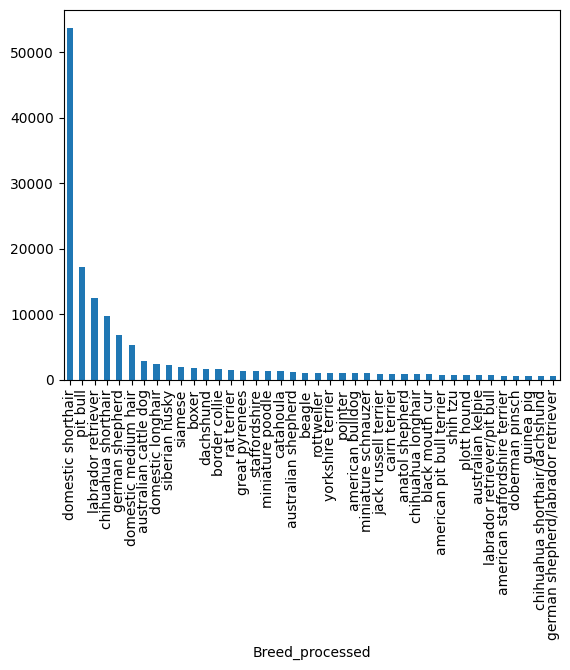

In [ ]:
#create barplot of breed
import matplotlib.pyplot as plt
df_joined['Breed_mixed'] = df_joined['Breed'].str.endswith(' Mix')
df_joined['Breed_processed'] = df_joined['Breed'].str.replace(' Mix', '')
df_joined['Breed_processed'] = df_joined['Breed_processed'].str.lower()
df_joined['Breed_processed'].value_counts().head(40).plot(kind='bar')


In [34]:
from transformers import BertTokenizer, BertModel

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model     = BertModel.from_pretrained('bert-base-uncased')

In [91]:
import torch
embed_vecs = []
breed_list = df_joined['Breed_processed'].to_list()
breed_list = breed_list[0:100]
# Get inputs to bert for this text string    
bert_inputs = bert_tokenizer(breed_list, return_tensors='pt',padding=True)

# Caluclate the bert outputs
with torch.no_grad():
    bert_outputs = bert_model(**bert_inputs)

# Final embedding vector is the average of all token vectors    
print(f"Data dim = {bert_outputs.last_hidden_state.shape}")
last_hidden_states = bert_outputs.last_hidden_state.mean(dim=1).squeeze(1)
        
print(f"Avg dim = {last_hidden_states.shape}")
    


    

Data dim = torch.Size([100, 10, 768])
Avg dim = torch.Size([100, 768])


torch.Size([20, 10, 768])